# Graph embedding using CBOW
[The CBOW model](https://arxiv.org/pdf/1606.04640.pdf) predicts the central word given the context words.

In our implementatation, as for the SkipGram model, since the batches walks are lazily generated, the memory requirements are minimal and the method can scale to very big graphs. It can also run on graphs like Monarch (150M edges and 50M nodes) provided that you use a GPU ([or better still a TPU](https://cloud.google.com/ai-platform/training/docs/using-tpus#console)) that is able to fit an embedding model that big, but that is just related to the shear number of nodes.

In [1]:
from embiggen import CBOW, NodeCBOWSequence
from ensmallen_graph import EnsmallenGraph

from tensorflow.keras.callbacks import EarlyStopping
import silence_tensorflow.auto
import numpy as np
from tensorflow.distribute import MirroredStrategy
from plot_keras_history import plot_history
from plot_keras_history.utils import chain_histories
import os
import pandas as pd

## Loading the graphs
We load the ppi graph as a weighted undirected graph.

In [2]:
graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    weights_column="weight"
)

As first thing, we plot a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [3]:
graph.report()

{'traps_rate': '0',
 'connected_components_number': '181',
 'nodes_number': '17185',
 'degrees_mean': '34.25941227814955',
 'degrees_mode': '1',
 'bidirectional_percentage': '1',
 'singleton_nodes': '0',
 'unique_edge_types_number': '0',
 'selfloops_percentage': '0',
 'strongly_connected_components_number': '181',
 'unique_node_types_number': '0',
 'edges_number': '588748',
 'is_directed': 'false',
 'density': '0.001993564869255138',
 'degrees_median': '11'}

## Creating the holdouts
For every one of these examples, we are going to use two experimental setups.

We split the graph into a training and validation components.

Particularly, the training partition will have the same number of connected components as the original graph, while the validation may have more.

We split the two datasets at $0.8$, as done in [Yue et al.](https://academic.oup.com/bioinformatics/article/36/4/1241/5581350).

We are going to us two different experimental setups:

- One, based on the [Yue et al.](https://academic.oup.com/bioinformatics/article/36/4/1241/5581350) and [Leskovec et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5108654/) experimental setups, where we completely separate training negatives from validation negatives and leave the validation parts of the graphs (both positives and negatives) as "holes" in the graph, neither negative nor positive. This may be slighly sconnected from the real scenario, where we cannot remove from a graph part of the validation edges since they are not known. In particular, the negatives edges used in the validation have the same cardinality as the validation positive edges.
- The second one, as close as possible to a real scenario, we will share the negative edges in both the training and validation. In particular in this scenario the validation positive edges appear as negatives during the training, as the assumption made during training with the available data is that any edge that does not appear in the available data is negative.

**For the context of CBOW or GloVe, both setups are the one and the same. The difference is relevant in SkipGram embedding and LinkPrediction.**

### Splitting the graph into the two components

In [4]:
training, validation = graph.holdout(42, 0.8)

### Preparing the experimental setup
For the experimental setup, we are using walk lengths of $100$ nodes, with batch size (number of walks to be considered in each batch) of $2^{7} = 128$.

We are going to use 20 walk iterations for each node.

We are going to use a window size of $4$, meaning $4$ nodes on the left and right of every central node. 

Consider that the first *window_size* values on the left and the right of the walks will be trimmed.

To generate the walks we will use the parameters $p$ and $q$ equal to $1.0$.

The *embedding_size* is $100$. For the porpose of the [NCE function negative samples](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss), we are going to use $10$. These are the number of negative classes to randomly sample per batch. This single sample of negative classes is evaluated for each element in the batch.

We are going to use Nadam as optimizer. We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.

The model will be trained up to $1000$ epochs.

#### Setting up the parameters

In [5]:
batch_size=2**7
walk_length=100
embedding_size=100
iterations=20
window_size=4
p=1.0
q=1.0
negatives_samples=10
patience=5
delta=0.0001

#### Creating the training and validation Keras sequences

In [6]:
training_sequence = NodeCBOWSequence(
    training,
    length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

validation_sequence = NodeCBOWSequence(
    graph, # Here we use the entire graph. This will only be used for the early stopping.
    length=walk_length,
    batch_size=batch_size,
    iterations=iterations,
    window_size=window_size,
    return_weight=1/p,
    explore_weight=1/q
)

## Creating the CBOW model
We are going to setup the model to use, if available, multiple GPUs.

In [7]:
strategy = MirroredStrategy()
with strategy.scope():
    model = CBOW(
        vocabulary_size=training.get_nodes_number(),
        embedding_size=embedding_size,
        window_size=window_size,
        negatives_samples=negatives_samples
    )

model.summary()

Model: "CBOW"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 100)       1718500     words_embedding[0][0]            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 100)          0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 8)]          0                                            
_______________________________________________________________________________________________

#### Loading preprocessed model weights
We can optionally load pre-processed model weights, obtained with the very same experimental setup and data, to quickly get through the training step:

In [8]:
model_weights = f"{model.name}_model_weights.h5"

if os.path.exists(model_weights):
    model.load_weights(model_weights)

If a training history is already available, we want to load it to avoid loosing informations:

In [9]:
history = None
training_history_path = f"{model.name}_training_history.csv"

if os.path.exists(training_history_path):
    history = pd.read_csv(training_history_path)

## Tuning the CBOW model

In [10]:
history = chain_histories(
    model.fit(
        training_sequence,
        steps_per_epoch=training_sequence.steps_per_epoch,
        validation_data=validation_sequence,
        validation_steps=validation_sequence.steps_per_epoch,
        epochs=1000,
        initial_epoch=0 if history is None else len(history),
        callbacks=[
            EarlyStopping(
                "val_loss",
                min_delta=delta,
                patience=patience
            )
        ]
    ),
    history
)

Epoch 101/1000
135/135 [==============================] - 44s 329ms/step - loss: 3.7816 - val_loss: 4.9396
Epoch 102/1000
135/135 [==============================] - 44s 323ms/step - loss: 5.7270 - val_loss: 5.9578
Epoch 103/1000
135/135 [==============================] - 44s 322ms/step - loss: 6.3321 - val_loss: 6.4355
Epoch 104/1000
135/135 [==============================] - 44s 323ms/step - loss: 6.1671 - val_loss: 6.1910
Epoch 105/1000
135/135 [==============================] - 44s 322ms/step - loss: 6.4196 - val_loss: 6.4177
Epoch 106/1000
135/135 [==============================] - 44s 323ms/step - loss: 6.0810 - val_loss: 6.4258


### Saving the model weights
We save the obtained model weights:

In [11]:
model.save_weights(model_weights)

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

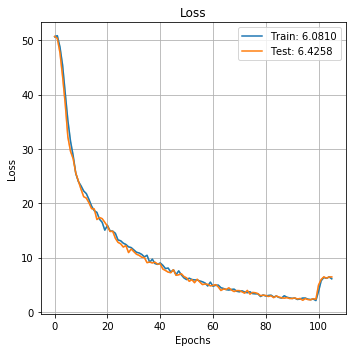

In [12]:
plot_history(history)

We can save the training history as follows:

In [13]:
history.to_csv(training_history_path, index=False)

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [14]:
np.save(f"{model.name}_embedding.npy", model.embedding)